#### Step 0. From the raw splite database extract just Colorado wildfires case  -> df_weather_RX.csv</br>

In [1]:
import re
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble as ske
from geopy import distance
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing
from subprocess import check_output

In [2]:
print(check_output(["ls", "raw"]).decode("utf8"))

FPA_FOD_20170508.sqlite



In [3]:
wf = sqlite3.connect('raw/FPA_FOD_20170508.sqlite')
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS FROM 'Fires'", wf)

In [4]:
df

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,2453403.5,0.10,A
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,2453137.5,0.25,A
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,2453156.5,0.10,A
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,2453189.5,0.10,A
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,2453189.5,0.10,A
...,...,...,...,...,...,...,...,...,...
1880460,2015,Missing/Undefined,40.481637,-122.389375,CA,2457291.5,2457291.5,0.01,A
1880461,2015,Miscellaneous,37.617619,-120.938570,CA,2457300.5,NaN,0.20,A
1880462,2015,Missing/Undefined,37.617619,-120.938570,CA,2457144.5,NaN,0.10,A
1880463,2015,Missing/Undefined,37.672235,-120.898356,CA,2457309.5,NaN,2.00,B


In [5]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['DURATION'] = df['CONT_DATE'] - df['DISCOVERY_DATE']
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()

In [6]:
df

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,DATE,DURATION,MONTH,DAY_OF_WEEK
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,2453403.5,0.10,A,2005-02-02,0.0,2,Wednesday
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,2453137.5,0.25,A,2004-05-12,0.0,5,Wednesday
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,2453156.5,0.10,A,2004-05-31,0.0,5,Monday
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,2453189.5,0.10,A,2004-06-28,5.0,6,Monday
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,2453189.5,0.10,A,2004-06-28,5.0,6,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,2015,Missing/Undefined,40.481637,-122.389375,CA,2457291.5,2457291.5,0.01,A,2015-09-26,0.0,9,Saturday
1880461,2015,Miscellaneous,37.617619,-120.938570,CA,2457300.5,NaN,0.20,A,2015-10-05,NaN,10,Monday
1880462,2015,Missing/Undefined,37.617619,-120.938570,CA,2457144.5,NaN,0.10,A,2015-05-02,NaN,5,Saturday
1880463,2015,Missing/Undefined,37.672235,-120.898356,CA,2457309.5,NaN,2.00,B,2015-10-14,NaN,10,Wednesday


In [7]:
df_CO = df[df['STATE']=='CO']
df_CO.reset_index(drop=True, inplace=True)

In [8]:
df_CO

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,DATE,DURATION,MONTH,DAY_OF_WEEK
0,2005,Lightning,39.292222,-105.183056,CO,2453535.5,2453535.5,0.5,B,2005-06-14,0.0,6,Tuesday
1,2005,Lightning,38.913333,-105.983611,CO,2453520.5,2453521.5,0.2,A,2005-05-30,1.0,5,Monday
2,2005,Campfire,39.100278,-106.367500,CO,2453542.5,2453542.5,0.1,A,2005-06-21,0.0,6,Tuesday
3,2005,Lightning,37.345000,-102.805833,CO,2453558.5,2453558.5,80.0,C,2005-07-07,0.0,7,Thursday
4,2005,Miscellaneous,38.891111,-105.431944,CO,2453534.5,2453534.5,2.5,B,2005-06-13,0.0,6,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34152,2015,Missing/Undefined,38.609900,-104.807800,CO,2457282.5,NaN,500.0,E,2015-09-17,NaN,9,Thursday
34153,2015,Missing/Undefined,39.421667,-103.878333,CO,2457280.5,NaN,610.0,E,2015-09-15,NaN,9,Tuesday
34154,2015,Missing/Undefined,37.545900,-105.007100,CO,2457310.5,NaN,270.0,D,2015-10-15,NaN,10,Thursday
34155,2015,Missing/Undefined,40.394700,-104.564600,CO,2457283.5,NaN,11699.0,G,2015-09-18,NaN,9,Friday


In [9]:
df_CO.to_csv('df_weather_co.csv')

</br>

#### Step 1. Make a dataframe for inventory -> df_inv</br></br> Step 2. Extract just inventories in Colorado from Step 1. result dataframe -> df_inv

In [10]:
df_inv_raw = pd.read_csv('weather/prcp-inventory.txt', header=None, skipinitialspace=True)
str(df_inv_raw.iloc[0]).split()[0:6]

list=[]
for i in range(len(df_inv_raw)):
    list.append(str(df_inv_raw.iloc[i]).split()[0:6])

df_inv = pd.DataFrame(list)
df_inv = df_inv[df_inv[5]=='CO']

df_inv = df_inv.reset_index(drop=True)
df_inv = df_inv.rename(columns={0:"0", 1:"Inventory", 2:"Latitude", 3:"Longitude", 4:"4", 5:"State"})
df_inv = df_inv.drop(['4'], axis=1)
df_inv

,0,Inventory,Latitude,Longitude,State
0,0,USC00050102,37.4011,-104.6547,CO
1,0,USC00050105,37.3169,-104.9503,CO
2,0,USC00050109,40.1550,-103.1417,CO
3,0,USC00050128,37.4417,-105.8614,CO
4,0,USC00050214,39.5008,-108.3794,CO
...,...,...,...,...,...
259,0,USW00093073,39.2231,-106.8683,CO
260,0,USW00094050,40.0489,-107.8853,CO
261,0,USW00094074,40.8067,-104.7553,CO
262,0,USW00094075,40.0353,-105.5408,CO


#### Step 3. Make a dataframe with dly-prcp-??pctl.txt -> df_pre

In [11]:
df_pre = pd.read_csv('weather/dly-prcp-25pctl.txt', header=None, delimiter=r"\s+")
df_pre.rename(columns={0:'Inventory'}, inplace=True)
df_pre

,Inventory,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,AQC00914000,1,26P,26P,26P,26P,26P,26S,26S,26P,...,27P,27P,27P,26P,26P,26P,26P,26P,26P,26P
1,AQC00914000,2,26P,26P,26P,26P,26P,26S,26S,26S,...,24S,24S,24S,24S,23S,23S,23S,23P,-8888,-8888
2,AQC00914000,3,23S,23S,22S,22S,22S,22S,22S,22S,...,21S,21S,21S,21S,21S,21P,21P,21P,21P,21P
3,AQC00914000,4,21P,21P,21P,21P,21P,21P,21P,21P,...,21P,20P,20P,20P,20P,20P,20P,19P,19P,-8888
4,AQC00914000,5,19P,19P,19P,18P,18P,18P,18P,18P,...,16P,15P,15P,15P,15P,15P,15P,15P,15P,15P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89803,WQW00041606,8,3P,3P,3P,3P,3P,3P,3P,3P,...,4P,4P,4P,4P,4P,4P,4P,3P,3P,3P
89804,WQW00041606,9,3P,3P,3P,3P,3P,3P,3P,3P,...,3P,3P,3P,3P,3P,3P,3P,3P,3P,-8888
89805,WQW00041606,10,3P,3P,3P,3P,3P,3P,3P,3P,...,3P,3P,3P,3P,3P,3P,3P,3P,3P,3P
89806,WQW00041606,11,3P,3P,3P,3P,3P,3P,3P,3P,...,3P,3P,3P,3P,3P,3P,3P,3P,3P,-8888


#### Step 4. Make a join by Inventory with inventory dataframe from Step 2 and the dataframe from Step 3 -> df_co_pre</br></br>Step 5. Extract just Colorado cases from the dataframe in Step 4 -> df_co_pre

In [12]:
df_co_pre = df_pre.join(df_inv.set_index('Inventory'), on='Inventory')
df_co_pre = df_co_pre[df_co_pre['State'] == 'CO']
df_co_pre = df_co_pre.reset_index(drop=True)
df_co_pre

,Inventory,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,0,Latitude,Longitude,State
0,USC00050102,1,2P,2P,2P,2P,2P,2P,2P,2P,...,2P,2P,2P,2P,2P,2P,0,37.4011,-104.6547,CO
1,USC00050102,2,2P,2P,2P,3P,3P,3P,3P,3P,...,4P,4P,5P,5P,-8888,-8888,0,37.4011,-104.6547,CO
2,USC00050102,3,5P,5P,5P,5P,5P,5P,6P,6P,...,5P,5P,5P,5P,5P,5P,0,37.4011,-104.6547,CO
3,USC00050102,4,5P,5P,5P,5P,5P,5P,5P,5P,...,5P,5P,5P,5P,5P,-8888,0,37.4011,-104.6547,CO
4,USC00050102,5,5P,5P,5P,5P,5P,5P,5P,5P,...,5P,5P,5P,5P,5P,5P,0,37.4011,-104.6547,CO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,USW00093058,8,3C,3C,3C,3C,3C,3C,3C,3C,...,3C,3C,3C,3C,3C,3C,0,38.2900,-104.4983,CO
2516,USW00093058,9,3C,3C,3C,3C,3C,2C,2C,2C,...,2C,2C,3C,3C,3C,-8888,0,38.2900,-104.4983,CO
2517,USW00093058,10,3C,3C,3C,3C,3C,3C,3C,2C,...,2C,2C,2C,2C,2C,2C,0,38.2900,-104.4983,CO
2518,USW00093058,11,2C,2C,2C,2C,2C,2C,2C,2C,...,2C,2C,2C,2C,2C,-8888,0,38.2900,-104.4983,CO


In [13]:
df_co_pre.drop(['0'], axis = 1, inplace=True)
df_co_pre.columns

Index(['Inventory',           1,           2,           3,           4,
                 5,           6,           7,           8,           9,
                10,          11,          12,          13,          14,
                15,          16,          17,          18,          19,
                20,          21,          22,          23,          24,
                25,          26,          27,          28,          29,
                30,          31,          32,  'Latitude', 'Longitude',
           'State'],
      dtype='object')

#### Step 6. Extract Longitude, Latitude columns from 'df_weather_co.csv' file and make a dataframe -> df_weather_loc</br></br>Step 7. Extract Longitude, Latitude columns from df_inv dataframe and make a dataframe -> df_inv_loc

In [14]:
df_weather = pd.read_csv('df_weather_co.csv', index_col = 0)
df_weather_loc = df_weather[['LATITUDE', 'LONGITUDE']]
df_inv_loc = df_inv[['Latitude', 'Longitude']]
print(df_inv_loc)
print(df_weather_loc)

    Latitude  Longitude
0    37.4011  -104.6547
1    37.3169  -104.9503
2    40.1550  -103.1417
3    37.4417  -105.8614
4    39.5008  -108.3794
..       ...        ...
259  39.2231  -106.8683
260  40.0489  -107.8853
261  40.8067  -104.7553
262  40.0353  -105.5408
263  40.2447  -108.9678

[264 rows x 2 columns]
        LATITUDE   LONGITUDE
0      39.292222 -105.183056
1      38.913333 -105.983611
2      39.100278 -106.367500
3      37.345000 -102.805833
4      38.891111 -105.431944
...          ...         ...
34152  38.609900 -104.807800
34153  39.421667 -103.878333
34154  37.545900 -105.007100
34155  40.394700 -104.564600
34156  40.819800 -105.084700

[34157 rows x 2 columns]


#### Step 8. Calculate the distance between a inventory from df_inv and wildfires location from df_weather_loc by using geopy method.</br> </br>Step 9.Next, make columns in df_weather_loc dataset as Distance and Inventory_Index with the closest inventory information from Step 8. -> df_weather_loc

In [15]:
dist = []
loc_index = []

for i in np.arange(len(df_weather_loc)):
    list1 = []
    for j in np.arange(len(df_inv_loc)):
        a = (df_inv_loc.loc[j, 'Latitude'], df_inv_loc.loc[j, 'Longitude'])
        b = (df_weather_loc.loc[i, 'LATITUDE'], df_weather_loc.loc[i, 'LONGITUDE'])
        list1.append(distance.distance(a,b).km)
    dist.append(min(list1))
    loc_index.append(list1.index(min(list1)))

df_weather_loc['Distance'] = pd.DataFrame(dist)
df_weather_loc['Inventory_Index'] = pd.DataFrame(loc_index)
df_weather_loc

<ipython-input-15-1bad30c518a4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_loc['Distance'] = pd.DataFrame(dist)
<ipython-input-15-1bad30c518a4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_loc['Inventory_Index'] = pd.DataFrame(loc_index)


,LATITUDE,LONGITUDE,Distance,Inventory_Index
0,39.292222,-105.183056,11.460354,34
1,38.913333,-105.983611,11.916755,5
2,39.100278,-106.367500,1.577794,210
3,37.345000,-102.805833,6.206311,197
4,38.891111,-105.431944,3.815104,123
...,...,...,...,...
34152,38.609900,-104.807800,11.942291,76
34153,39.421667,-103.878333,29.350907,253
34154,37.545900,-105.007100,20.897144,217
34155,40.394700,-104.564600,11.457235,92


#### Step 10. Use Inventory_Index information in df_weather_loc dataframe to get the inventory information from df_inv dataframe. Then, make a inventory column in df_weather_loc dataframe.

In [16]:
list = []
for i in np.arange(len(df_weather_loc)):
    list.append(df_inv.loc[df_weather_loc['Inventory_Index'][i]].at['Inventory'])
    
df_weather_loc['Inventory'] = pd.DataFrame(list)

<ipython-input-16-ecf0c933bd30>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_loc['Inventory'] = pd.DataFrame(list)


In [17]:
df_weather_loc

,LATITUDE,LONGITUDE,Distance,Inventory_Index,Inventory
0,39.292222,-105.183056,11.460354,34,USC00051528
1,38.913333,-105.983611,11.916755,5,USC00050263
2,39.100278,-106.367500,1.577794,210,USC00058501
3,37.345000,-102.805833,6.206311,197,USC00057866
4,38.891111,-105.431944,3.815104,123,USC00054742
...,...,...,...,...,...
34152,38.609900,-104.807800,11.942291,76,USC00053063
34153,39.421667,-103.878333,29.350907,253,USW00093010
34154,37.545900,-105.007100,20.897144,217,USC00058781
34155,40.394700,-104.564600,11.457235,92,USC00053553


#### Step 11. Change the data type of columns in df_co_pre or df_co_temp dataframe from object to int.

In [18]:
# For Precipitation
df_co_pre.rename(columns={1:'Month', 2:1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9, 11:10, 12:11, 13:12, 14:13, 15:14, 16:15, 17:16, 18:17, 19:18, 20:19, 21:20, 22:21, 23:22, 24:23, 25:24, 26:25, 27:26, 28:27, 29:28, 30:29, 31:30, 32:31}, inplace=True)
df_co_pre

# For Temperature
# df_co_pre.rename(columns={'1':'Month', '2':1, '3':2, '4':3, '5':4, '6':5, '7':6, '8':7, '9':8, '10':9, '11':10, '12':11, '13':12, '14':13, '15':14, '16':15, '17':16, '18':17, '19':18, '20':19, '21':20, '22':21, '23':22, '24':23, '25':24, '26':25, '27':26, '28':27, '29':28, '30':29, '31':30, '32':31}, inplace=True)
# df_co_pre

,Inventory,Month,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,Latitude,Longitude,State
0,USC00050102,1,2P,2P,2P,2P,2P,2P,2P,2P,...,2P,2P,2P,2P,2P,2P,2P,37.4011,-104.6547,CO
1,USC00050102,2,2P,2P,2P,3P,3P,3P,3P,3P,...,4P,4P,4P,5P,5P,-8888,-8888,37.4011,-104.6547,CO
2,USC00050102,3,5P,5P,5P,5P,5P,5P,6P,6P,...,6P,5P,5P,5P,5P,5P,5P,37.4011,-104.6547,CO
3,USC00050102,4,5P,5P,5P,5P,5P,5P,5P,5P,...,5P,5P,5P,5P,5P,5P,-8888,37.4011,-104.6547,CO
4,USC00050102,5,5P,5P,5P,5P,5P,5P,5P,5P,...,5P,5P,5P,5P,5P,5P,5P,37.4011,-104.6547,CO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,USW00093058,8,3C,3C,3C,3C,3C,3C,3C,3C,...,3C,3C,3C,3C,3C,3C,3C,38.2900,-104.4983,CO
2516,USW00093058,9,3C,3C,3C,3C,3C,2C,2C,2C,...,2C,2C,2C,3C,3C,3C,-8888,38.2900,-104.4983,CO
2517,USW00093058,10,3C,3C,3C,3C,3C,3C,3C,2C,...,2C,2C,2C,2C,2C,2C,2C,38.2900,-104.4983,CO
2518,USW00093058,11,2C,2C,2C,2C,2C,2C,2C,2C,...,2C,2C,2C,2C,2C,2C,-8888,38.2900,-104.4983,CO


#### Step 12. Extract day information from df_weather dataframe and make a day columns</br></br>Step 13. Extract Inventory column from df_weather_loc dataframe and put it into df_weather dataframe

In [19]:
# df_weather.drop(['Unnamed: 0'], axis = 1, inplace=True)
df_weather['DAY'] = pd.DatetimeIndex(df_weather['DATE']).day
df_weather['INVENTORY'] = df_weather_loc['Inventory']
df_weather

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,DATE,DURATION,MONTH,DAY_OF_WEEK,DAY,INVENTORY
0,2005,Lightning,39.292222,-105.183056,CO,2453535.5,2453535.5,0.5,B,2005-06-14,0.0,6,Tuesday,14,USC00051528
1,2005,Lightning,38.913333,-105.983611,CO,2453520.5,2453521.5,0.2,A,2005-05-30,1.0,5,Monday,30,USC00050263
2,2005,Campfire,39.100278,-106.367500,CO,2453542.5,2453542.5,0.1,A,2005-06-21,0.0,6,Tuesday,21,USC00058501
3,2005,Lightning,37.345000,-102.805833,CO,2453558.5,2453558.5,80.0,C,2005-07-07,0.0,7,Thursday,7,USC00057866
4,2005,Miscellaneous,38.891111,-105.431944,CO,2453534.5,2453534.5,2.5,B,2005-06-13,0.0,6,Monday,13,USC00054742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34152,2015,Missing/Undefined,38.609900,-104.807800,CO,2457282.5,NaN,500.0,E,2015-09-17,NaN,9,Thursday,17,USC00053063
34153,2015,Missing/Undefined,39.421667,-103.878333,CO,2457280.5,NaN,610.0,E,2015-09-15,NaN,9,Tuesday,15,USW00093010
34154,2015,Missing/Undefined,37.545900,-105.007100,CO,2457310.5,NaN,270.0,D,2015-10-15,NaN,10,Thursday,15,USC00058781
34155,2015,Missing/Undefined,40.394700,-104.564600,CO,2457283.5,NaN,11699.0,G,2015-09-18,NaN,9,Friday,18,USC00053553


#### Step 14. Find the same inventory information in df_co_pre dataframe with df_weather dataframe. Then, find the row with the same month. In the row, put the weather data that matches to the day information in df_weather dataframe into list.

In [20]:
list = []
for i in np.arange(len(df_weather)):
    try:
        a = df_co_pre.loc[df_co_pre['Inventory']==df_weather['INVENTORY'][i]].loc[df_co_pre['Month']==df_weather['MONTH'][i]].loc[:, df_weather['DAY'][i]].values
        a = str(a)
        list.append(re.findall(r'\d+', a)[0])
    except:
        list.append(np.nan)
        pass

#### Step 15. Make a new column in df_weather dataframe with the list made in Step 13 as 'pre_??pctl' or 'tavg'

In [21]:
df_weather['pre_25pctl'] = pd.DataFrame(list)
df_weather

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,DATE,DURATION,MONTH,DAY_OF_WEEK,DAY,INVENTORY,pre_25pctl
0,2005,Lightning,39.292222,-105.183056,CO,2453535.5,2453535.5,0.5,B,2005-06-14,0.0,6,Tuesday,14,USC00051528,4
1,2005,Lightning,38.913333,-105.983611,CO,2453520.5,2453521.5,0.2,A,2005-05-30,1.0,5,Monday,30,USC00050263,3
2,2005,Campfire,39.100278,-106.367500,CO,2453542.5,2453542.5,0.1,A,2005-06-21,0.0,6,Tuesday,21,USC00058501,2
3,2005,Lightning,37.345000,-102.805833,CO,2453558.5,2453558.5,80.0,C,2005-07-07,0.0,7,Thursday,7,USC00057866,4
4,2005,Miscellaneous,38.891111,-105.431944,CO,2453534.5,2453534.5,2.5,B,2005-06-13,0.0,6,Monday,13,USC00054742,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34152,2015,Missing/Undefined,38.609900,-104.807800,CO,2457282.5,NaN,500.0,E,2015-09-17,NaN,9,Thursday,17,USC00053063,5
34153,2015,Missing/Undefined,39.421667,-103.878333,CO,2457280.5,NaN,610.0,E,2015-09-15,NaN,9,Tuesday,15,USW00093010,2
34154,2015,Missing/Undefined,37.545900,-105.007100,CO,2457310.5,NaN,270.0,D,2015-10-15,NaN,10,Thursday,15,USC00058781,4
34155,2015,Missing/Undefined,40.394700,-104.564600,CO,2457283.5,NaN,11699.0,G,2015-09-18,NaN,9,Friday,18,USC00053553,3


In [22]:
df_weather.to_csv('df_weather_co.csv')

**Repeat the process from Step 1 to Step 15 for 50pctl, 75pct and tavg by adding a new column in df_weather_co.csv**

</br>

#### Step 16. Clean the data more with df_weather.csv

In [25]:
df_weather_co_test = pd.read_csv('df_weather_co.csv', index_col = 0)

In [26]:
df_weather_co_test

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,DATE,DURATION,MONTH,DAY_OF_WEEK,DAY,INVENTORY,pre_25pctl,pre_50pctl,pre_75pctl,tavg
0,2005,Lightning,39.292222,-105.183056,CO,2453535.5,2453535.5,0.5,B,2005-06-14,0.0,6,Tuesday,14,USC00051528,4.0,9.0,27.0,621
1,2005,Lightning,38.913333,-105.983611,CO,2453520.5,2453521.5,0.2,A,2005-05-30,1.0,5,Monday,30,USC00050263,3.0,7.0,21.0,475
2,2005,Campfire,39.100278,-106.367500,CO,2453542.5,2453542.5,0.1,A,2005-06-21,0.0,6,Tuesday,21,USC00058501,2.0,5.0,13.0,539
3,2005,Lightning,37.345000,-102.805833,CO,2453558.5,2453558.5,80.0,C,2005-07-07,0.0,7,Thursday,7,USC00057866,4.0,15.0,36.0,756
4,2005,Miscellaneous,38.891111,-105.431944,CO,2453534.5,2453534.5,2.5,B,2005-06-13,0.0,6,Monday,13,USC00054742,4.0,10.0,21.0,548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34152,2015,Missing/Undefined,38.609900,-104.807800,CO,2457282.5,NaN,500.0,E,2015-09-17,NaN,9,Thursday,17,USC00053063,5.0,13.0,27.0,605
34153,2015,Missing/Undefined,39.421667,-103.878333,CO,2457280.5,NaN,610.0,E,2015-09-15,NaN,9,Tuesday,15,USW00093010,2.0,6.0,15.0,594
34154,2015,Missing/Undefined,37.545900,-105.007100,CO,2457310.5,NaN,270.0,D,2015-10-15,NaN,10,Thursday,15,USC00058781,4.0,12.0,33.0,527
34155,2015,Missing/Undefined,40.394700,-104.564600,CO,2457283.5,NaN,11699.0,G,2015-09-18,NaN,9,Friday,18,USC00053553,3.0,10.0,22.0,644


In [27]:
df_weather_co_test = df_weather_co_test[df_weather_co_test['FIRE_YEAR']<=2010]
df_weather_co_test_simple = df_weather_co_test[['STAT_CAUSE_DESCR', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'pre_25pctl', 'pre_50pctl', 'pre_75pctl', 'tavg']]

In [28]:
df_weather_co_test_simple

,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,pre_25pctl,pre_50pctl,pre_75pctl,tavg
0,Lightning,0.5,B,4.0,9.0,27.0,621
1,Lightning,0.2,A,3.0,7.0,21.0,475
2,Campfire,0.1,A,2.0,5.0,13.0,539
3,Lightning,80.0,C,4.0,15.0,36.0,756
4,Miscellaneous,2.5,B,4.0,10.0,21.0,548
...,...,...,...,...,...,...,...
27001,Missing/Undefined,230.0,D,5.0,14.0,29.0,428
27002,Missing/Undefined,200.0,D,5.0,14.0,29.0,451
27003,Lightning,450.0,E,3.0,9.0,22.0,700
27004,Lightning,350.0,E,4.0,15.0,34.0,497


In [29]:
le = preprocessing.LabelEncoder()
df_weather_co_test_simple['STAT_CAUSE_DESCR'] = le.fit_transform(df_weather_co_test_simple['STAT_CAUSE_DESCR'])
df_weather_co_test_simple['FIRE_SIZE_CLASS'] = le.fit_transform(df_weather_co_test_simple['FIRE_SIZE_CLASS'])
df_weather_co_test_simple

<ipython-input-29-ffd34465ea6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_co_test_simple['STAT_CAUSE_DESCR'] = le.fit_transform(df_weather_co_test_simple['STAT_CAUSE_DESCR'])
<ipython-input-29-ffd34465ea6f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_co_test_simple['FIRE_SIZE_CLASS'] = le.fit_transform(df_weather_co_test_simple['FIRE_SIZE_CLASS'])


,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,pre_25pctl,pre_50pctl,pre_75pctl,tavg
0,6,0.5,1,4.0,9.0,27.0,621
1,6,0.2,0,3.0,7.0,21.0,475
2,1,0.1,0,2.0,5.0,13.0,539
3,6,80.0,2,4.0,15.0,36.0,756
4,7,2.5,1,4.0,10.0,21.0,548
...,...,...,...,...,...,...,...
27001,8,230.0,3,5.0,14.0,29.0,428
27002,8,200.0,3,5.0,14.0,29.0,451
27003,6,450.0,4,3.0,9.0,22.0,700
27004,6,350.0,4,4.0,15.0,34.0,497


In [30]:
df_weather_co_test_simple = df_weather_co_test_simple.dropna()
df_weather_co_test_simple

,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,pre_25pctl,pre_50pctl,pre_75pctl,tavg
0,6,0.5,1,4.0,9.0,27.0,621
1,6,0.2,0,3.0,7.0,21.0,475
2,1,0.1,0,2.0,5.0,13.0,539
3,6,80.0,2,4.0,15.0,36.0,756
4,7,2.5,1,4.0,10.0,21.0,548
...,...,...,...,...,...,...,...
27001,8,230.0,3,5.0,14.0,29.0,428
27002,8,200.0,3,5.0,14.0,29.0,451
27003,6,450.0,4,3.0,9.0,22.0,700
27004,6,350.0,4,4.0,15.0,34.0,497


In [31]:
df_weather_co_test_simple = df_weather_co_test_simple.drop(df_weather_co_test_simple[df_weather_co_test_simple['pre_25pctl']== 6666].index)

In [32]:
df_simple = df_weather_co_test_simple.copy()
df_simple['tavg'] = df_simple['tavg']/10

In [33]:
df_simple

,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,pre_25pctl,pre_50pctl,pre_75pctl,tavg
0,6,0.5,1,4.0,9.0,27.0,62.1
1,6,0.2,0,3.0,7.0,21.0,47.5
2,1,0.1,0,2.0,5.0,13.0,53.9
3,6,80.0,2,4.0,15.0,36.0,75.6
4,7,2.5,1,4.0,10.0,21.0,54.8
...,...,...,...,...,...,...,...
27001,8,230.0,3,5.0,14.0,29.0,42.8
27002,8,200.0,3,5.0,14.0,29.0,45.1
27003,6,450.0,4,3.0,9.0,22.0,70.0
27004,6,350.0,4,4.0,15.0,34.0,49.7


In [34]:
# Check the if there are 'Null' values in the dataframe
df_simple.isnull().sum()

STAT_CAUSE_DESCR    0
FIRE_SIZE           0
FIRE_SIZE_CLASS     0
pre_25pctl          0
pre_50pctl          0
pre_75pctl          0
tavg                0
dtype: int64

In [35]:
df_simple.to_csv('df_simple.csv')

**df_simple.csv is the final dataset for the analysis**

</br>

#### Step 17. Check correlaton matrix of weather data with df_weather.csv

In [36]:
df_simple = pd.read_csv('df_simple.csv', index_col = 0)
df_simple

,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,pre_25pctl,pre_50pctl,pre_75pctl,tavg
0,6,0.5,1,4.0,9.0,27.0,62.1
1,6,0.2,0,3.0,7.0,21.0,47.5
2,1,0.1,0,2.0,5.0,13.0,53.9
3,6,80.0,2,4.0,15.0,36.0,75.6
4,7,2.5,1,4.0,10.0,21.0,54.8
...,...,...,...,...,...,...,...
27001,8,230.0,3,5.0,14.0,29.0,42.8
27002,8,200.0,3,5.0,14.0,29.0,45.1
27003,6,450.0,4,3.0,9.0,22.0,70.0
27004,6,350.0,4,4.0,15.0,34.0,49.7


In [37]:
df_simple.drop(['FIRE_SIZE'], axis=1, inplace=True)

In [38]:
df_simple

,STAT_CAUSE_DESCR,FIRE_SIZE_CLASS,pre_25pctl,pre_50pctl,pre_75pctl,tavg
0,6,1,4.0,9.0,27.0,62.1
1,6,0,3.0,7.0,21.0,47.5
2,1,0,2.0,5.0,13.0,53.9
3,6,2,4.0,15.0,36.0,75.6
4,7,1,4.0,10.0,21.0,54.8
...,...,...,...,...,...,...
27001,8,3,5.0,14.0,29.0,42.8
27002,8,3,5.0,14.0,29.0,45.1
27003,6,4,3.0,9.0,22.0,70.0
27004,6,4,4.0,15.0,34.0,49.7


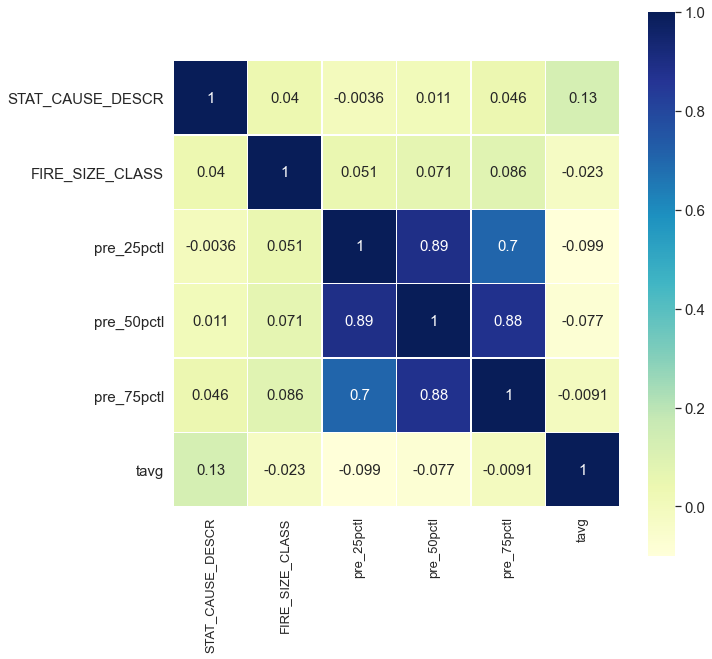

In [39]:
corr = df_simple.corr()

sns.set(rc={'figure.figsize':(10,10)})
cm = sns.heatmap(corr, linewidths=0.5, annot=True, square=True, cmap='YlGnBu', annot_kws={'size':15})
cm.set_xticklabels(cm.get_ymajorticklabels(), fontsize = 13)
cm.set_yticklabels(cm.get_ymajorticklabels(), fontsize = 15)
cbar = cm.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

plt.show()

</br>

#### Step 18. T-test

In [40]:
from scipy import stats

In [41]:
a = df_simple['STAT_CAUSE_DESCR']
b = df_simple['tavg']
c = df_simple['FIRE_SIZE_CLASS']
d = df_simple['pre_25pctl']
e = df_simple['pre_50pctl']
f = df_simple['pre_75pctl']

In [42]:
# t-검정 계산
t, p = stats.ttest_ind(b, a)
print("t = " + str(t))
print("p = " + str(p))

t = 698.7803490388532
p = 0.0


In [43]:
t, p = stats.ttest_ind(a, c)
print("t = " + str(t))
print("p = " + str(p))

t = 325.42917478666124
p = 0.0


In [44]:
t, p = stats.ttest_ind(a, d)
print("t = " + str(t))
print("p = " + str(p))

t = 81.9869135433512
p = 0.0


In [45]:
t, p = stats.ttest_ind(a, e)
print("t = " + str(t))
print("p = " + str(p))

t = -174.93032365089496
p = 0.0


In [46]:
t, p = stats.ttest_ind(a, f)
print("t = " + str(t))
print("p = " + str(p))

t = -391.49726084520455
p = 0.0


In [47]:
t, p = stats.ttest_ind(b, c)
print("t = " + str(t))
print("p = " + str(p))

t = 776.103691441185
p = 0.0


In [48]:
t, p = stats.ttest_ind(d, c)
print("t = " + str(t))
print("p = " + str(p))

t = 277.67547071922417
p = 0.0


In [49]:
t, p = stats.ttest_ind(e, c)
print("t = " + str(t))
print("p = " + str(p))

t = 419.7971753227922
p = 0.0


In [51]:
t, p = stats.ttest_ind(f, c)
print("t = " + str(t))
print("p = " + str(p))

t = 520.8666633015574
p = 0.0


</br>

#### Step 19. Check correlaton matrix of wildfires data

In [62]:
df_wild = df.copy()

In [63]:
df_wild 

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,DATE,DURATION,MONTH,DAY_OF_WEEK
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,2453403.5,0.10,A,2005-02-02,0.0,2,Wednesday
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,2453137.5,0.25,A,2004-05-12,0.0,5,Wednesday
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,2453156.5,0.10,A,2004-05-31,0.0,5,Monday
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,2453189.5,0.10,A,2004-06-28,5.0,6,Monday
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,2453189.5,0.10,A,2004-06-28,5.0,6,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,2015,Missing/Undefined,40.481637,-122.389375,CA,2457291.5,2457291.5,0.01,A,2015-09-26,0.0,9,Saturday
1880461,2015,Miscellaneous,37.617619,-120.938570,CA,2457300.5,NaN,0.20,A,2015-10-05,NaN,10,Monday
1880462,2015,Missing/Undefined,37.617619,-120.938570,CA,2457144.5,NaN,0.10,A,2015-05-02,NaN,5,Saturday
1880463,2015,Missing/Undefined,37.672235,-120.898356,CA,2457309.5,NaN,2.00,B,2015-10-14,NaN,10,Wednesday


In [64]:
df_wild['DATE'] = pd.to_datetime(df_wild['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df_wild['MONTH'] = pd.DatetimeIndex(df_wild['DATE']).month
df_wild['DAY_OF_WEEK'] = df_wild['DATE'].dt.day_name()
df_wild

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,DATE,DURATION,MONTH,DAY_OF_WEEK
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,2453403.5,0.10,A,2005-02-02,0.0,2,Wednesday
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,2453137.5,0.25,A,2004-05-12,0.0,5,Wednesday
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,2453156.5,0.10,A,2004-05-31,0.0,5,Monday
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,2453189.5,0.10,A,2004-06-28,5.0,6,Monday
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,2453189.5,0.10,A,2004-06-28,5.0,6,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,2015,Missing/Undefined,40.481637,-122.389375,CA,2457291.5,2457291.5,0.01,A,2015-09-26,0.0,9,Saturday
1880461,2015,Miscellaneous,37.617619,-120.938570,CA,2457300.5,NaN,0.20,A,2015-10-05,NaN,10,Monday
1880462,2015,Missing/Undefined,37.617619,-120.938570,CA,2457144.5,NaN,0.10,A,2015-05-02,NaN,5,Saturday
1880463,2015,Missing/Undefined,37.672235,-120.898356,CA,2457309.5,NaN,2.00,B,2015-10-14,NaN,10,Wednesday


In [65]:
df_wild['STAT_CAUSE_DESCR'] = le.fit_transform(df_wild['STAT_CAUSE_DESCR'])
df_wild['STATE'] = le.fit_transform(df_wild['STATE'])
df_wild['DAY_OF_WEEK'] = le.fit_transform(df_wild['DAY_OF_WEEK'])
df_wild.drop('DISCOVERY_DATE', axis=1, inplace=True)
df_wild.drop('CONT_DATE', axis=1, inplace=True)
df_wild.drop('FIRE_SIZE_CLASS', axis=1, inplace=True)
df_wild.drop('DATE', axis=1, inplace=True)
df_wild.drop('DURATION', axis=1, inplace=True)
df_wild

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,FIRE_SIZE,MONTH,DAY_OF_WEEK
0,2005,7,40.036944,-121.005833,4,0.10,2,6
1,2004,6,38.933056,-120.404444,4,0.25,5,6
2,2004,3,38.984167,-120.735556,4,0.10,5,1
3,2004,6,38.559167,-119.913333,4,0.10,6,1
4,2004,6,38.559167,-119.933056,4,0.10,6,1
...,...,...,...,...,...,...,...,...
1880460,2015,8,40.481637,-122.389375,4,0.01,9,2
1880461,2015,7,37.617619,-120.938570,4,0.20,10,1
1880462,2015,8,37.617619,-120.938570,4,0.10,5,2
1880463,2015,8,37.672235,-120.898356,4,2.00,10,6


In [66]:
corr_wild = df_wild.corr()

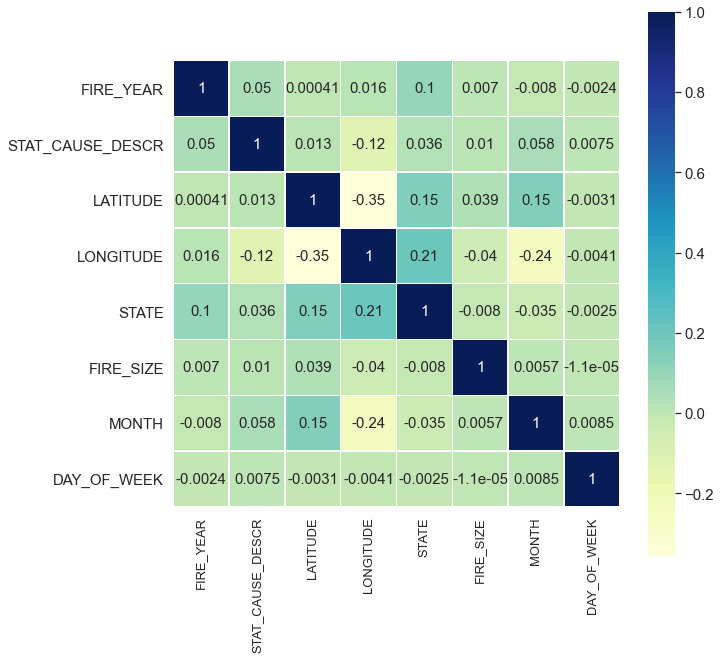

In [67]:
sns.set(rc={'figure.figsize':(10,10)})
cm = sns.heatmap(corr_wild, linewidths=0.5, annot=True, square=True, cmap='YlGnBu', annot_kws={'size':15})
cm.set_xticklabels(cm.get_ymajorticklabels(), fontsize = 13)
cm.set_yticklabels(cm.get_ymajorticklabels(), fontsize = 15)
cbar = cm.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

plt.show()